In [10]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, ConcatDataset, random_split, DataLoader
import torch.nn.functional as F
from torch.nn import init
import torchaudio
import librosa
import librosa.display
import IPython.display as ipd
import os
import matplotlib.pyplot as plt

# Urban Sound Dataset

In [11]:
class UrbanSoundDataset(Dataset):

    def __init__(self, annotations_file, audio_data_path, transformation, target_sample_rate, num_samples, device):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_data_path = audio_data_path
        self.device = device
        self.transformation = transformation.to(device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = signal.to(device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        mel_spec = self.transformation(signal)
        mel_spec = torchaudio.transforms.AmplitudeToDB(top_db = 80)(mel_spec)
        return mel_spec, label
    
    def _get_audio_sample_path(self, index):
        fold = f"fold{self.annotations.iloc[index, 5]}"
        path = os.path.join(self.audio_data_path, fold, self.annotations.iloc[index, 0])
        return path 
    
    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 6]
    
    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate).cuda()
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal 
    
    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal 
    
    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            # [1, 1, 1] -> [1, 1, 1, 0, 0, 0]
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

In [12]:
ANNOTATIONS_FILE = r"/kaggle/input/urbansound8k/UrbanSound8K.csv"
AUDIO_DATA_PATH = r"/kaggle/input/urbansound8k"
SAMPLE_RATE = 44100
NUM_SAMPLES = 44100*4


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate = SAMPLE_RATE,
    n_fft = 1024,
    hop_length=512,
    n_mels=64)

usd = UrbanSoundDataset(ANNOTATIONS_FILE, AUDIO_DATA_PATH, mel_spectrogram, SAMPLE_RATE, NUM_SAMPLES, device)
print(f"There are {len(usd)} samples in the dataset")

cuda
There are 8732 samples in the dataset


# Visualize Waveforms and log Mel Spectrograms 
NOTE: To visualize waveform return signal in the get item function of the above Urban Sound Dataset

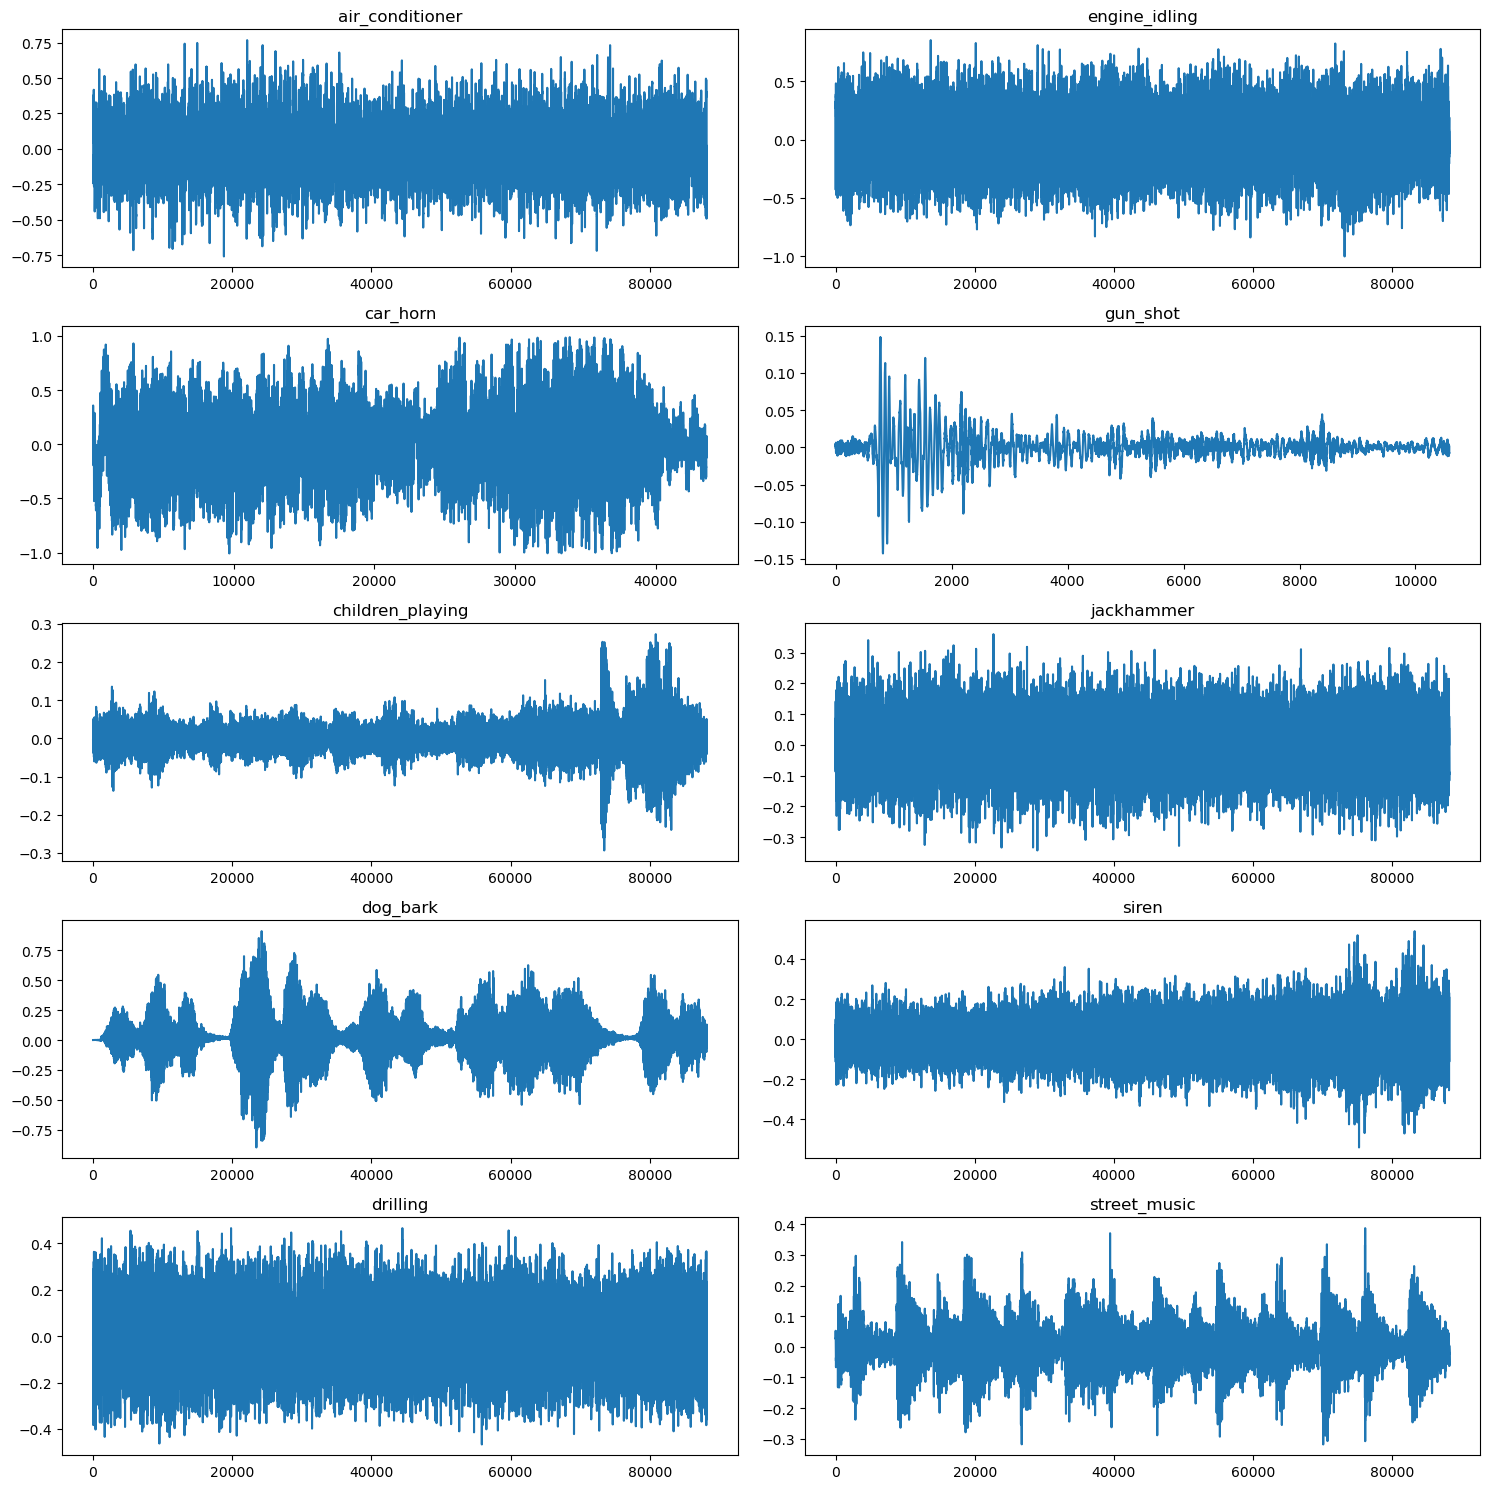

In [5]:
data_path = "/kaggle/input/urbansound8k"
meta_df = pd.read_csv("/kaggle/input/urbansound8k/UrbanSound8K.csv")
meta_df['relative_path'] = '/fold' + meta_df['fold'].astype(str) + '/' + meta_df['slice_file_name'].astype(str)
df = meta_df[['relative_path', 'classID']]

# Randomly select one sample of each class
random_samples = meta_df.groupby('class').sample(1)
audio_samples, labels = random_samples['relative_path'].tolist(), random_samples['class'].tolist()

# Visualize the waveforms
fig, axs = plt.subplots(5, 2, figsize=(15, 15))
index = 0
for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(data_path + audio_samples[index])
        axs[row][col].plot(audio_file)
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()
plt.savefig('visualize_audio.png')
plt.show()

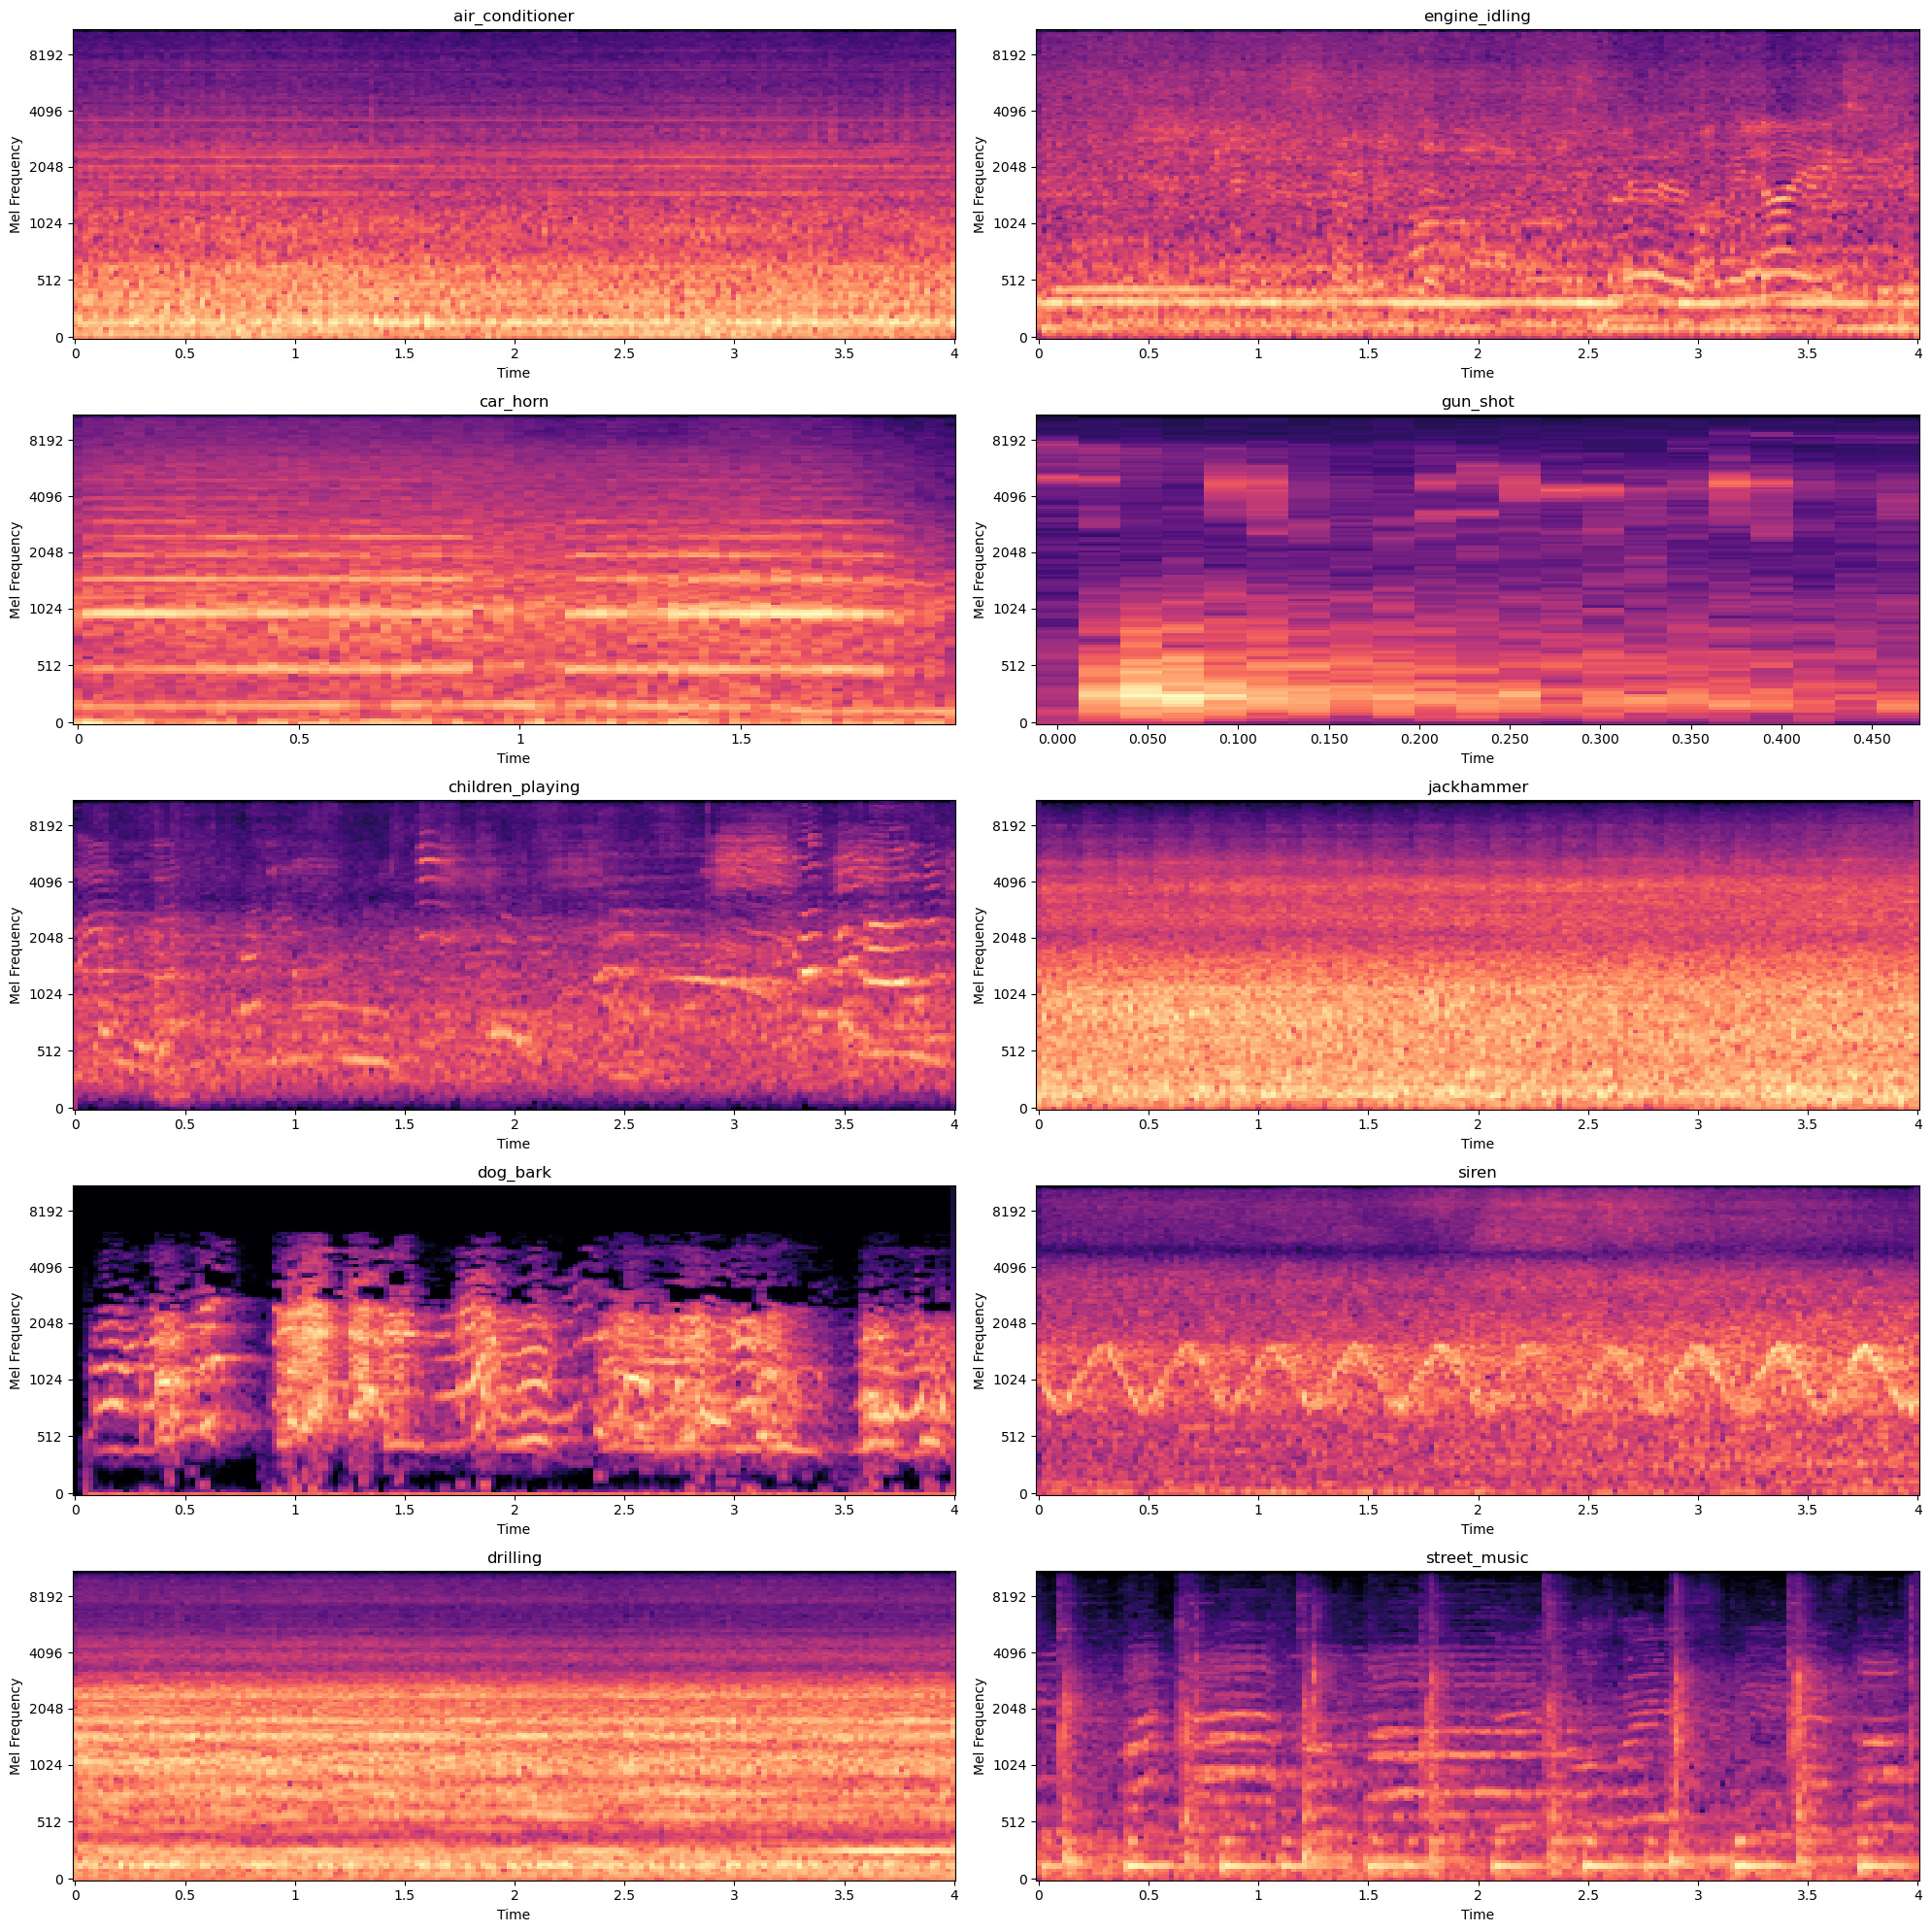

In [6]:
n_fft = 1024
hop_length = 512

fig, axs = plt.subplots(5, 2, figsize=(20, 20))
index = 0

for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(data_path + audio_samples[index])
        mel_spectrogram = librosa.feature.melspectrogram(y=audio_file, sr=sample_rate, n_fft=n_fft, hop_length=hop_length)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        librosa.display.specshow(log_mel_spectrogram, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='mel', ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        axs[row][col].set_xlabel('Time')
        axs[row][col].set_ylabel('Mel Frequency')
        index += 1

fig.tight_layout()
plt.savefig('visualize_mel_spec')
plt.show()


# Dataloaders

In [13]:
# Random split of 80:20 between training and testing
num_items = len(usd)
num_train = round(num_items * 0.8)
num_test = num_items - num_train
train, test_ds = random_split(usd, [num_train, num_test])
# Random split of 80:20 between training and validation
num_trainds = round(num_train*0.8)
num_valds = num_train - num_trainds
train_ds, val_ds = random_split(train, [num_trainds, num_valds])

# Create training, validation and test data loaders
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=16, shuffle=False)

In [14]:
print(f"Train Samples = {len(train_ds)}")
print(f"Validation Samples = {len(val_ds)}")
print(f"Test Samples = {len(test_ds)}")

Train Samples = 5589
Validation Samples = 1397
Test Samples = 1746


In [15]:
sig, label = next(iter(train_dl))
print(sig.shape, label.shape)

torch.Size([16, 1, 64, 345]) torch.Size([16])


# Models

In [16]:
import torch.nn.functional as F
from torch.nn import init

class CNN(nn.Module):

    def __init__(self):
        super().__init__()

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        self.conv1layer = nn.Sequential(self.conv1, self.relu1, self.bn1)

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        self.conv2layer = nn.Sequential(self.conv2, self.relu2, self.bn2)

        # Third Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        self.conv3layer = nn.Sequential(self.conv3, self.relu3, self.bn3)

        # Fourth Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        self.conv4layer = nn.Sequential(self.conv4, self.relu4, self.bn4)

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=10)
 
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv1layer(x)
        x = self.conv2layer(x)
        x = self.conv3layer(x)
        x = self.conv4layer(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

In [17]:
!pip install torchsummary

In [18]:
from torchsummary import summary
model = CNN().to(device)
summary(model, (1, 64, 345))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 8, 66, 347]              80
            Conv2d-2           [-1, 8, 66, 347]              80
              ReLU-3           [-1, 8, 66, 347]               0
              ReLU-4           [-1, 8, 66, 347]               0
       BatchNorm2d-5           [-1, 8, 66, 347]              16
       BatchNorm2d-6           [-1, 8, 66, 347]              16
            Conv2d-7          [-1, 16, 33, 174]           1,168
            Conv2d-8          [-1, 16, 33, 174]           1,168
              ReLU-9          [-1, 16, 33, 174]               0
             ReLU-10          [-1, 16, 33, 174]               0
      BatchNorm2d-11          [-1, 16, 33, 174]              32
      BatchNorm2d-12          [-1, 16, 33, 174]              32
           Conv2d-13           [-1, 32, 17, 87]           4,640
           Conv2d-14           [-1, 32,

# Training

In [19]:
def train(model, train_dl, val_dl, epochs, print_loss=True):
    torch.cuda.empty_cache()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=epochs,
                                                anneal_strategy='linear')
    history=[]

    for epoch in range(epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0
        for i, data in enumerate(train_dl):
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss +=  loss.item()
            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]
        
        num_batches = len(train_dl)
        avg_loss = running_loss / num_batches
        train_acc = correct_prediction/total_prediction

        # Validation phase
        correct_pred = 0
        total_pred  = 0
        model.eval()
        # Disable gradient updates
        with torch.no_grad():
          for data in val_dl:
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)
            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s
            # Get predictions
            outputs = model(inputs)
            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            # Count of predictions that matched the target label
            correct_pred += (prediction == labels).sum().item()
            total_pred += prediction.shape[0]
          
          val_acc = correct_pred/total_pred

        result = {}
        result['avg_train_loss'] = avg_loss
        result['train_acc'] = train_acc
        result['val_acc'] = val_acc

        history.append(result)
        
        if (print_loss): 
          print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Train Acc: {train_acc:.2f}, Val_acc: {val_acc:.2f}')
        
        if(val_acc > 0.9):
          break
    
    print('Finished Training')

    return history

def test (model, test_dl):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates
  with torch.no_grad():
    for data in test_dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]
    
  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')
  return acc

In [20]:
num_epochs=25
history = train(model, train_dl, val_dl, num_epochs)
test_acc = test(model, test_dl)

Epoch: 0, Loss: 2.10, Train Acc: 0.25, Val_acc: 0.30
Epoch: 1, Loss: 1.87, Train Acc: 0.35, Val_acc: 0.39
Epoch: 2, Loss: 1.66, Train Acc: 0.44, Val_acc: 0.45
Epoch: 3, Loss: 1.47, Train Acc: 0.50, Val_acc: 0.48
Epoch: 4, Loss: 1.35, Train Acc: 0.54, Val_acc: 0.50
Epoch: 5, Loss: 1.23, Train Acc: 0.59, Val_acc: 0.54
Epoch: 6, Loss: 1.10, Train Acc: 0.63, Val_acc: 0.62
Epoch: 7, Loss: 1.01, Train Acc: 0.67, Val_acc: 0.66
Epoch: 8, Loss: 0.91, Train Acc: 0.70, Val_acc: 0.66
Epoch: 9, Loss: 0.84, Train Acc: 0.72, Val_acc: 0.68
Epoch: 10, Loss: 0.76, Train Acc: 0.76, Val_acc: 0.73
Epoch: 11, Loss: 0.69, Train Acc: 0.78, Val_acc: 0.75
Epoch: 12, Loss: 0.64, Train Acc: 0.79, Val_acc: 0.75
Epoch: 13, Loss: 0.62, Train Acc: 0.80, Val_acc: 0.76
Epoch: 14, Loss: 0.57, Train Acc: 0.83, Val_acc: 0.78
Epoch: 15, Loss: 0.54, Train Acc: 0.83, Val_acc: 0.81
Epoch: 16, Loss: 0.50, Train Acc: 0.85, Val_acc: 0.80
Epoch: 17, Loss: 0.49, Train Acc: 0.85, Val_acc: 0.81
Epoch: 18, Loss: 0.47, Train Acc: 0.86

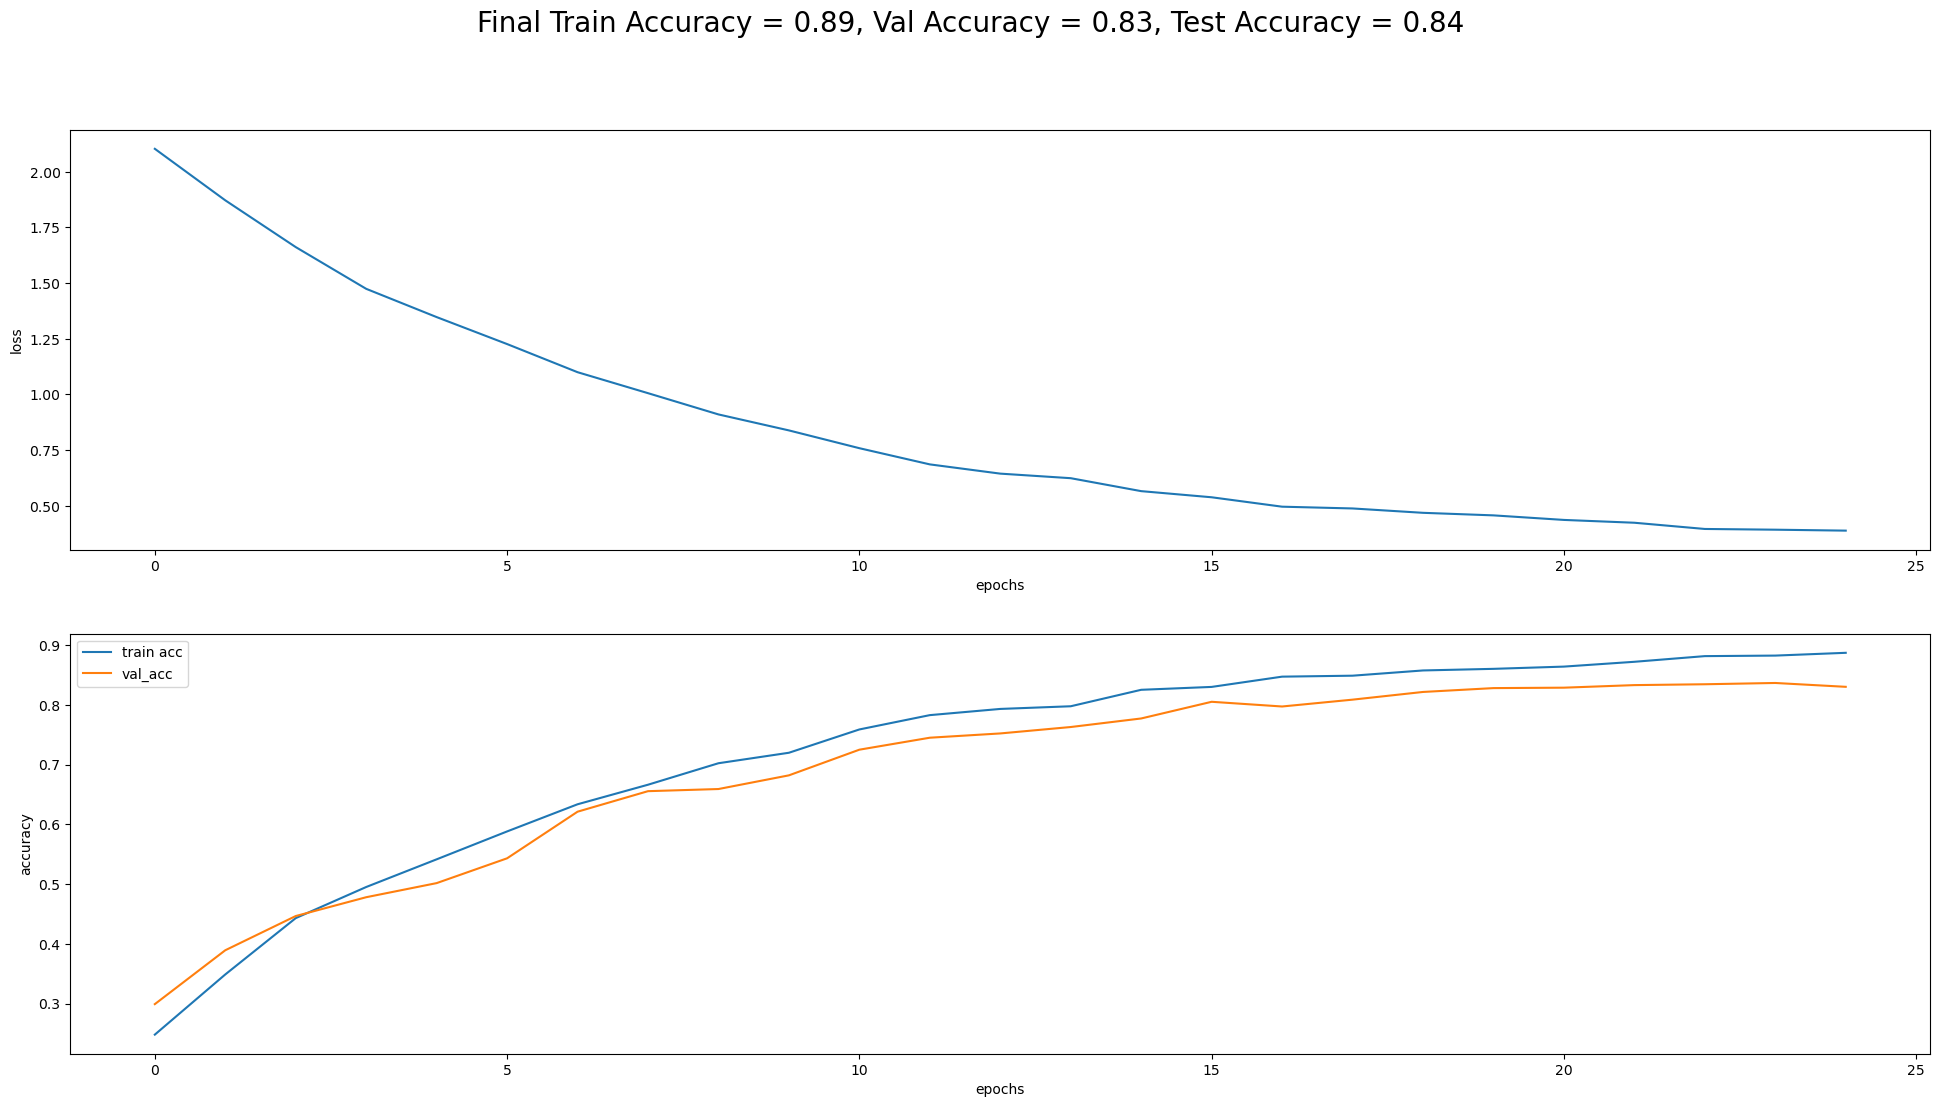

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(24,12))
plt.subplot(2, 1, 1)
plt.plot([history[ind]['avg_train_loss'] for ind in range(len(history))])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.subplot(2, 1, 2)
plt.plot([history[ind]['train_acc'] for ind in range(len(history))], label='train acc')
plt.plot([history[ind]['val_acc'] for ind in range(len(history))], label = 'val_acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.suptitle(f"Final Train Accuracy = {history[len(history)-1]['train_acc']:.2f}, Val Accuracy = {history[len(history)-1]['val_acc']:.2f}, Test Accuracy = {test_acc:.2f}", fontsize=20)
plt.legend()
plt.savefig('train_test_loss')

In [22]:
torch.save(model.state_dict(), '/kaggle/working/model.pt')

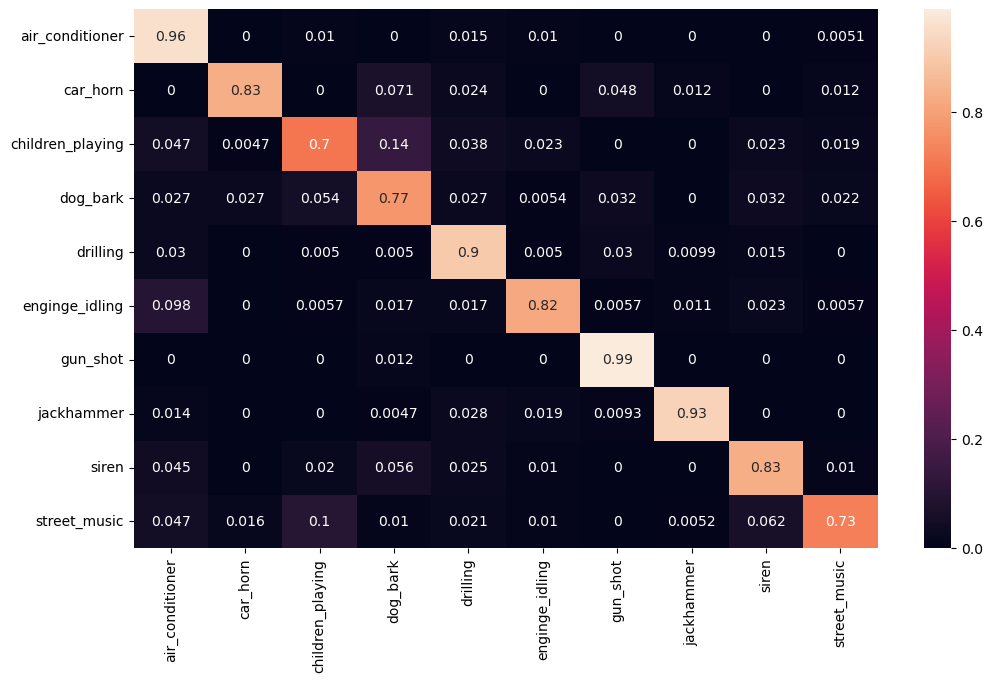

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []
  

  # Disable gradient updates
with torch.no_grad():
    for data in test_dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # Count of predictions that matched the target label
      y_pred.extend(prediction.cpu())
      y_true.extend(labels.cpu())
    

# constant for classes
classes = ('air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'enginge_idling',
        'gun_shot', 'jackhammer', 'siren', 'street_music')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('confusion_matrix.png')